In [1]:
from abc import ABC, abstractmethod
from dataclasses import dataclass
from typing import Protocol
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
import pandas as pd
from datetime import datetime

class DataLoader():
    def __init__(self, api_key: str, secret_key: str, ticker_symbol: str, granularity: TimeFrame=TimeFrame.Minute , start_date: datetime = datetime(2025, 6, 4), end_date: datetime = datetime(2025, 6, 5)):
        self.api_key = api_key
        self.secret_key = secret_key
        # assume 1 symboil for now, can refator to list of symbols later
        self.ticker_symbol = ticker_symbol
        self.granularity = granularity  # 1-min bars
        self.start_date = start_date
        self.end_date = end_date
        self._client = StockHistoricalDataClient(self.api_key, self.secret_key)
    
    def fetch(self) -> pd.DataFrame:
        """Download bars and return a tidy DataFrame."""

        request_params = StockBarsRequest(
        symbol_or_symbols=self.ticker_symbol,
        timeframe=self.granularity,  # 1-min bars
        start=self.start_date,
        end=self.end_date)
        bars = self._client.get_stock_bars(request_params).df
        bars = bars.loc[self.ticker_symbol]
        bars = bars.reset_index()
        bars['timestamp'] = pd.to_datetime(bars['timestamp'])
        bars.set_index('timestamp', inplace=True)
        return bars
    
"""
example usage:
"""
loader = DataLoader(
    api_key="PK9RY3ZC8KV02FH05TYB",
    secret_key="8L8Xa6OZRShc3sjY3vktGRcnAZV12pUuXpfvJQW7",
    ticker_symbol=["AAPL"],
    granularity=TimeFrame.Minute,
    start_date=datetime(2020, 6, 5),
    end_date=datetime(2025, 6, 5),
)

#bars = loader.fetch()               # pandas DataFrame ready for indicators
#print(bars.head())
#bars_1yr = loader.fetch()               # pandas DataFrame ready for indicators
bars_5yr = loader.fetch() 

### **opening high comparison**

In [13]:
from dataclasses import dataclass, field
from datetime import time, timedelta
import pandas as pd
import numpy as np
from collections import deque


price_hi = lambda bar: max(bar.open, bar.high, bar.close)
price_lo = lambda bar: min(bar.open, bar.low,  bar.close)

@dataclass(slots=True)
class IdentifyOpeningRange:
    # ---for opening range ---
    window: int = 15                    # minutes to build the range
    entry_deadline: time = time(11, 0)  # no trades after this
    # ---for stop loss and target price calculation---
    stop_loss_ratio:float = 0.5 # a percentage ratio given width of the opening range
    risk_reward_ratio: float =2.0 # a risk/reward ratio to set my target price (typically 1-3)


    # --- internal state ---
    _high: float = field(init=False, default=np.nan, repr=False)
    _low:  float = field(init=False, default=np.nan, repr=False)
    _range_fixed: bool = field(init=False, default=False, repr=False) # internal state, so that no need to calculate range again once set to True
    _start_ts: pd.Timestamp | None = field(init=False, default=None, repr=False)
    # --- for stop loss and target price calc ---
    _stop_n_target_fixed   : bool  = field(init=False, default=False, repr=False) # return True once stop loss and target price are calculated
    _stop_loss: float = field(init=False, default=np.nan, repr=False)
    _target_price: float = field(init=False, default=np.nan, repr=False)
    # ---- for NR7 ---
    _nr7_buf: deque[float] = field(init=False,
                                   default_factory=lambda: deque(maxlen=7),
                                   repr=False)

    # ------------------------------------------------------------------
    def cal_opening_range(self, ts: pd.Timestamp, bar: pd.Series) -> None:
        """
        Feed bars in chronological order.
        Returns True *once* price breaks above opening-range high,
        but only between (09:30 + window) and entry_deadline.
        """
        if ts.time() < time(9, 30):              # ignore pre-market
            return

        if self._start_ts is None:               # first regular bar
            self._start_ts = ts

        window_end = self._start_ts + timedelta(minutes=self.window)

        # ── build range ───────────────────────────────────────────────
        if not self._range_fixed:
            if ts < window_end:
                self._high = price_hi(bar) if np.isnan(self._high) else max(self._high, price_hi(bar))
                self._low  = price_lo(bar) if np.isnan(self._low)  else min(self._low,  price_lo(bar))
            else:
                self._range_fixed = True         # lock the range

    #trying out different liquidity assessments, without level 2 for now
    #def nr7(self, bar: pd.Series) -> bool:
    #    """return True if narrow range 7 (NR7) condition is met."""
    #def nr7(self, bar: pd.Series) -> bool:
    #    """
    #    True **once** the current bar’s range (high–low) is narrower than
    #    each of the previous six bars (classic NR-7).  Stream-safe.

    #    ─ Logic ──────────────────────────────────────────────────────────
    #    1. Keep a rolling deque of the last 7 intraday ranges.
    #    2. When the buffer is full, compare *current* range (buf[-1])
    #    to the min(range[0:6]).  If narrower ⇒ NR-7.
    #    3. After it fires, set a flag so it doesn’t keep firing on every
    #    subsequent bar of the same session.
    #    """
    #    rng = bar.high - bar.low                 # intraday range of this bar
    #    self._nr7_buf.append(rng)

        # need 7 observations before we can test
    #    if len(self._nr7_buf) < 7 or self._nr7_ready:
    #        return False

    #    prev6_min = min(list(self._nr7_buf)[:-1])    # exclude current bar
    #    if rng < prev6_min:
    #        self._nr7_ready = True                   # lock until next day
    #        return True
    #    return False

    #def reset_daily_state(self):
    #    """
    #    Call this at the first bar of each new session
    #    (or inside your existing daily reset block).
    #    """
    #    self._nr7_buf.clear()
    #    self._nr7_ready = False
        
    # ------------------------------------------------------------------
    # entry conditions below: (AND all conditions)
    
    def price_signal(self, bar: pd.Series) -> bool:
        """return True if price is above opening range high. (long only)"""
        if not self._range_fixed:
            raise RuntimeError("Opening range not fixed yet")
        return bar.open > self._high or bar.high > self._high
    def before_deadline(self, ts: pd.Timestamp) -> bool:
        """return True if time is before trading deadline."""
        return ts.time() < self.entry_deadline
    
    # ------------------------------------------------------------------
    # calculate stop loss and target price
    def cal_stop_n_target(self, entry_price: float) -> None:
        # note only calculating for long trades
        if not self._range_fixed:
            raise RuntimeError("Opening range not fixed yet")
        width = self._high - self._low
        risk  = self.stop_loss_ratio * width
        self._stop_loss   = entry_price - risk
        self._target_price = entry_price + risk * self.risk_reward_ratio
        self._stop_n_target_fixed  = True

    # ------------------------------------------------------------------
    # exit conditions below: (OR all conditions)
    def stop_hit(self, price: float) -> bool:
        """return True if price is below stop loss."""
        if not self._stop_n_target_fixed:
            raise RuntimeError("stop loss n target not set yet")
        return price <= self._stop_loss

    def target_hit(self, price: float) -> bool:
        """return True if price is above target."""
        if not self._stop_n_target_fixed:
            raise RuntimeError("stop loss n target not set yet")
        return price >= self._target_price




### **backtest**

without fees and slippage

In [23]:
from dataclasses import dataclass
from datetime import time, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------
@dataclass
class ORBConfig:
    window: int = 15
    entry_deadline: time = time(11, 0)
    stop_ratio: float = 0.5
    rr_ratio: float = 2.0
    hold_minutes: int = 90


class ORBBacktest1:
    def __init__(self, bars_utc: pd.DataFrame, cfg: ORBConfig = ORBConfig(),
                 cash_start: float = 100_000.0):
        """
        bars_utc : 1-min OHLC dataframe in UTC
        cfg       : ORBConfig dataclass
        """
        self.cfg = cfg
        self.bars = (bars_utc.copy()
                     .tz_convert("America/New_York")
                     .loc[lambda x: x.index.time >= time(9, 30)])
        self.cash_start = cash_start

        # internal state
        self.cash   = cash_start
        self.shares = 0
        self.equity_log = []          # list[(ts, equity)]
        self.trade_log  = []          # list[(ts, side, price, qty)]

    # ------------------------------------------------------------------ #
    def _price3(self, bar) -> float:
        return (bar.open + bar.high + bar.low) / 3

    # ------------------------------------------------------------------ #
    def run(self) -> None:
        for session, day_df in self.bars.groupby(self.bars.index.date):

            orb = IdentifyOpeningRange(
                window=self.cfg.window,
                entry_deadline=self.cfg.entry_deadline,
                stop_loss_ratio=self.cfg.stop_ratio,
                risk_reward_ratio=self.cfg.rr_ratio,
            )
            entry_ts = None

            for ts, bar in day_df.iterrows():
                orb.cal_opening_range(ts, bar)

                # ENTRY
                if (self.shares == 0 and orb._range_fixed
                        and orb.before_deadline(ts)
                        and orb.price_signal(bar)):

                    entry_px = self._price3(bar)
                    orb.cal_stop_n_target(entry_px)
                    qty = int(self.cash // entry_px)
                    if qty:
                        self.cash   -= qty * entry_px
                        self.shares  = qty
                        entry_ts     = ts
                        self.trade_log.append((ts, "BUY", entry_px, qty))

                # EXIT
                if self.shares:
                    held = ((ts - entry_ts).total_seconds() / 60)
                    if (orb.stop_hit(bar.low)                # long stop
                            or orb.target_hit(bar.high)      # long target
                            or held >= self.cfg.hold_minutes):
                        exit_px = self._price3(bar)
                        self.cash += self.shares * exit_px
                        self.trade_log.append((ts, "SELL", exit_px, self.shares))
                        self.shares, entry_ts = 0, None

                # end-of-day equity snapshot
            last_px = self._price3(day_df.iloc[-1])
            eod_ts  = (pd.Timestamp.combine(session, time(16, 0))
                        .tz_localize(day_df.index.tz))
            self.equity_log.append((eod_ts, self.cash + self.shares * last_px))

    # ------------------------------------------------------------------ #
    def get_equity_log(self) -> pd.Series:
        """Returns a daily equity Series (forward-filled)."""
        eq = (pd.DataFrame(self.equity_log, columns=["ts", "equity"])
                .set_index("ts")
                .asfreq("1D")
                .ffill())
        return eq["equity"]

    # ------------------------------------------------------------------ #
    def summary(self) -> None:
        equity = self.get_equity_log()
        total_return = (equity.iloc[-1] / equity.iloc[0] - 1) * 100
        trades = len(self.trade_log) // 2
        print(f"Final equity : ${equity.iloc[-1]:,.2f}")
        print(f"Total return : {total_return:.2f}%")
        print(f"Round-trip trades : {trades}")

    # ------------------------------------------------------------------ #
    def plot(self) -> None:
        equity = self.get_equity_log()
        plt.figure(figsize=(10, 4))
        equity.plot()
        plt.title("Equity curve – ORB back-test")
        plt.ylabel("Account value (USD)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


with fees & slippage backtest:

In [21]:

# --------------------------------------------------------------------------- #
# Strategy configuration
# --------------------------------------------------------------------------- #
@dataclass
class ORBConfig:
    window: int = 15
    entry_deadline: time = time(11, 0)
    stop_ratio: float = 0.5
    rr_ratio: float = 2.0
    hold_minutes: int = 90

# --------------------------------------------------------------------------- #
# Back‑tester
# --------------------------------------------------------------------------- #
class ORBBacktest:
    """Single-symbol intraday ORB tester integrating IdentifyOpeningRange."""

    def __init__(self, bars_utc: pd.DataFrame, ticker: str,
                 cfg: ORBConfig | None = None, cost: CostModel | None = None,
                 cash_start_gbp: float = 1_000.0, fx_rate: float = 1.30):
        self.ticker = ticker.upper()
        self.cfg = cfg or ORBConfig()
        self.cost = cost or CostModel(gbp_cash=cash_start_gbp)
        self.fx_rate = fx_rate

        # Keep only RTH bars and convert to New-York time
        self.bars = (bars_utc.tz_convert("America/New_York")
                     .loc[lambda x: x.index.time >= time(9, 30)])

        self.shares: int = 0
        self.trade_log:  list[tuple[pd.Timestamp, str, float, int, float]] = []
        self.equity_log: list[tuple[pd.Timestamp, float]] = []

    # ---------- helpers -------------------------------------------------
    @staticmethod
    def _price3(bar) -> float:
        return (bar.open + bar.high + bar.low) / 3          # mid-price proxy

    # ---------- main loop ----------------------------------------------
    def run(self) -> None:
        for session, day_df in self.bars.groupby(self.bars.index.date):

            orb = IdentifyOpeningRange(window=self.cfg.window,
                                       entry_deadline=self.cfg.entry_deadline,
                                       stop_loss_ratio=self.cfg.stop_ratio,
                                       risk_reward_ratio=self.cfg.rr_ratio)
            entry_ts = None

            for ts, bar in day_df.iterrows():
                orb.cal_opening_range(ts, bar)

                # ─── ENTRY ────────────────────────────────────────────
                if (self.shares == 0 and orb._range_fixed
                        and orb.before_deadline(ts)
                        and orb.price_signal(bar)):

                    mkt_px = self._price3(bar)

                    # buying-power in USD (GBP cash converted – existing debit)
                    usd_avail = (float(self.cost.gbp_cash) * self.fx_rate
                                 - max(float(self.cost.usd_credit), 0.0))
                    qty = int(usd_avail // mkt_px)
                    if qty <= 0:
                        continue

                    fill_px, fee = self.cost.buy(self.ticker, qty, mkt_px)
                    orb.cal_stop_n_target(fill_px)

                    self.shares  = qty
                    entry_ts     = ts
                    self.trade_log.append((ts, "BUY", fill_px, qty, fee))

                # ─── EXIT ─────────────────────────────────────────────
                if self.shares:
                    held = (ts - entry_ts).total_seconds() / 60
                    if (orb.stop_hit(bar.low)
                            or orb.target_hit(bar.high)
                            or held >= self.cfg.hold_minutes):

                        fill_px, fee = self.cost.sell(self.ticker,
                                                       self.shares,
                                                       self._price3(bar))
                        self.trade_log.append((ts, "SELL",
                                               fill_px, self.shares, fee))
                        self.shares, entry_ts = 0, None

            # ─── end-of-day bookkeeping ───────────────────────────────
            self.cost.fx_settlement(self.fx_rate)

            mkt_px = self._price3(day_df.iloc[-1])
            eod_ts = (pd.Timestamp.combine(session, time(16))
                      .tz_localize(day_df.index.tz))
            equity = float(self.cost.gbp_cash) + self.shares * mkt_px / self.fx_rate
            self.equity_log.append((eod_ts, equity))

    # ---------- analytics ----------------------------------------------
    def equity_series(self) -> pd.Series:
        return (pd.DataFrame(self.equity_log, columns=["ts", "equity"])
                .set_index("ts").asfreq("1D").ffill()["equity"])

    def sharpe(self, risk_free: float = 0.0) -> float:
        eq = self.equity_series()
        daily = eq.pct_change().dropna()
        excess = daily - risk_free / 252
        sigma  = excess.std(ddof=0)
        return 0.0 if sigma == 0 else np.sqrt(252) * excess.mean() / sigma

    def summary(self) -> None:
        eq  = self.equity_series()
        pnl = eq.iloc[-1] - eq.iloc[0]
        print(f"Final equity : £{eq.iloc[-1]:,.2f}")
        print(f"Total P&L    : £{pnl:,.2f}  ({pnl/eq.iloc[0]*100:.2f} %)")
        print(f"Sharpe ratio : {self.sharpe():.2f}")
        print(f"Round-trips  : {len(self.trade_log)//2}")

    def plot(self) -> None:
        self.equity_series().plot(figsize=(10, 4))
        plt.title(f"Equity curve (GBP) – {self.ticker}")
        plt.ylabel("Account value (£)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


(without fees and slippage)

Final equity : $212,152.15
Total return : 111.34%
Round-trip trades : 973


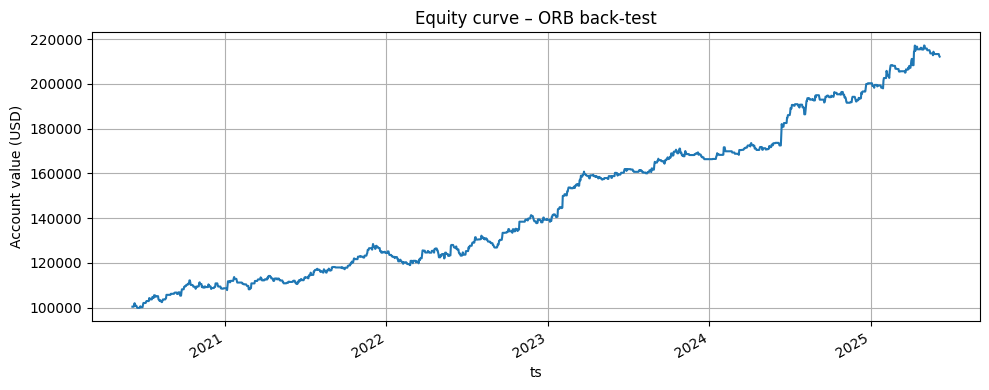

In [24]:
# ------------------- Example use ---------------------------------------
bt = ORBBacktest1(bars_5yr,cash_start=100_000.0)       # bars_5yr must be 1-min OHLC in UTC
bt.run()
bt.summary()
bt.plot()
eq_series = bt.get_equity_log()

with fees & slippage run sample:

Final equity : £87,767.20
Total P&L    : £-12,532.13  (-12.49 %)
Sharpe ratio : -0.27
Round-trips  : 980


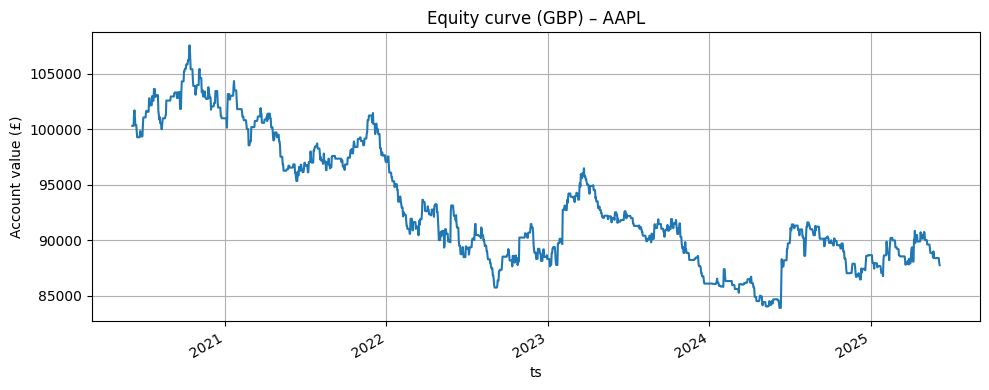

In [ ]:
cost = CostModel(gbp_cash=100_000)      # new ledger with £10k
bt = ORBBacktest(bars_utc=bars_5yr, cost=cost, ticker = "AAPL")
bt.run()
bt.summary()
bt.plot()

### **fees & slippage**

In [ ]:
# v2 refactored CostModel
from __future__ import annotations

import pandas as pd
import numpy as np
from dataclasses import dataclass
from datetime import time
from decimal import Decimal, ROUND_HALF_UP
import matplotlib.pyplot as plt

# --------------------------------------------------------------------------- #
# Utility helpers
# --------------------------------------------------------------------------- #
CENT = Decimal("0.01")
GBP_PENNY = Decimal("0.01")

def _round_usd(x: Decimal) -> Decimal:
    """Round to the nearest US cent using bankers' rounding."""
    return x.quantize(CENT, rounding=ROUND_HALF_UP)


def _round_gbp(x: Decimal) -> Decimal:
    """Round to the nearest penny."""
    return x.quantize(GBP_PENNY, rounding=ROUND_HALF_UP)

# --------------------------------------------------------------------------- #
# Brokerage cost engine
# --------------------------------------------------------------------------- #
class CostModel:
    """Interactive Brokers tiered pricing for US shares (simplified)."""

    def __init__(self, gbp_cash: float | Decimal = 3_000.0) -> None:
        self.gbp_cash: Decimal = _round_gbp(Decimal(gbp_cash))
        self.positions: dict[str, int] = {}
        self.usd_credit: Decimal = Decimal("0")  # +ve means we owe USD for purchases

    # ---------- internal fee helpers -------------------------------------- #
    @staticmethod
    def _commission(notional: Decimal) -> Decimal:
        fee = max(Decimal("0.0005") * notional, Decimal("1.70"))
        return _round_usd(min(fee, Decimal("39.00")))

    @staticmethod
    def _taker(qty: int) -> Decimal:
        return _round_usd(Decimal("0.003") * qty)

    @staticmethod
    def _clearing_buy(qty: int) -> Decimal:
        return _round_usd(Decimal("0.000225") * qty)

    @staticmethod
    def _clearing_sell(qty: int) -> Decimal:
        variable = Decimal("0.000225") * qty + Decimal("0.000166") * qty
        fixed_cap = Decimal("8.30")
        return _round_usd(min(variable, fixed_cap))

    # ---------- public trade interface ------------------------------------ #
    def buy(self, ticker: str, qty: int, mid_px_usd: float) -> tuple[float, float]:
        """Execute a marketable buy order, return (fill_px, total_fee) in USD."""
        qty = int(qty)
        if qty <= 0:
            raise ValueError("Quantity must be positive.")
        mid = Decimal(str(mid_px_usd))
        fill = _round_usd(mid * Decimal("1.0001"))  # +1 bp slippage
        notional = fill * qty

        fee = (self._commission(notional) +
               self._taker(qty) +
               self._clearing_buy(qty))

        self.usd_credit += notional + fee  # cash outflow (GBP unchanged until FX sweep)
        self.positions[ticker] = self.positions.get(ticker, 0) + qty
        return float(fill), float(fee)

    def sell(self, ticker: str, qty: int, mid_px_usd: float) -> tuple[float, float]:
        """Execute a marketable sell order, return (fill_px, total_fee) in USD."""
        qty = int(qty)
        if qty <= 0:
            raise ValueError("Quantity must be positive.")
        if self.positions.get(ticker, 0) < qty:
            raise ValueError("Attempting to sell more shares than held.")

        mid = Decimal(str(mid_px_usd))
        fill = _round_usd(mid * Decimal("0.9999"))  # −1 bp slippage
        notional = fill * qty

        fee = (self._commission(notional) +
               self._taker(qty) +
               self._clearing_sell(qty))

        self.usd_credit -= notional - fee  # cash inflow reduces debit (or increases credit)
        self.positions[ticker] -= qty
        return float(fill), float(fee)

    # ---------- FX sweep --------------------------------------------------- #
    def fx_settlement(self, spot_usd_gbp: float) -> None:
        """Convert net USD to / from GBP at IBKR AutoFX rates, then reset ledger."""
        if abs(self.usd_credit) < Decimal("0.000001"):
            return  # nothing to do

        spot = Decimal(str(spot_usd_gbp))
        if self.usd_credit > 0:  # we bought shares – owe USD, convert GBP → USD
            rate = spot * Decimal("1.0003")
            self.gbp_cash -= _round_gbp(self.usd_credit / rate)
        else:  # we sold shares – receive USD, convert USD → GBP
            rate = spot * Decimal("0.9997")
            self.gbp_cash += _round_gbp(abs(self.usd_credit) / rate)

        self.usd_credit = Decimal("0")


v1 below

In [ ]:
# create a class to model the cost of trading
from typing import Dict

# it's importance to highlight several assumptions for the CostModel:
# 1. I use tiered SmartRouting, since it's generally cheaper than fixed and smart routing optimise for price, especially when liquidity is tight
# 2. assume a slippage of 0.01% for large-caps
# 3. price assumptions are based on UK - USD denominated trades.
# 4. based on 2, commission is min(max(0.05% of Trade Value, USD 1.70),USD 39.00), and Exchange Fees, Clearing Fees applies.
# 5. Since I'm using SmartRouting, I do not know about the exact exchange, taker is almost universally USD 0.003/share, maker (rebate) varies between exchanges
# 6. Since my strategy is ORB, assume Marketable Limit Orders , so rebate is not applicable, need to pay the taker on sell.
# 7. clearning fee: Buy: USD 0.000225/share (NSCC / DTCC clearing fee + FINRA CAT fee); Sell: USD 0.000225/share + min(USD 0.000166/share, USD 8.30/trade)
# 8. FX settlement fee (UK ISA): settleds once per day, fx_rate = spot * 1.0003 if net buy and spot * 0.9997 on net sell. (AutoFX)

# links: 
# on commission: https://www.interactivebrokers.com/en/pricing/commissions-stocks-europe.php?re=europe
# on exchange fees 
# (NASDAQ): https://www.interactivebrokers.com/en/accounts/fees/INETstkfee.php?utm_source=chatgpt.com
# (NYSE): https://www.interactivebrokers.com/en/accounts/fees/NYSEstkfee.php?utm_source=chatgpt.com
# (ARCA): https://www.interactivebrokers.com/en/accounts/fees/ARCAstkfee.php?utm_source=chatgpt.com
# mandatory quarterly routing stats report: "Interactive Brokers - Held NMS Stocks and Options Order Routing Public Report"

class CostModel:
    def __init__(self, account_cash: float = 3000.0, equity:dict = None,usd_credit: float = 0.0):
        self.account_cash = account_cash # cash in GBP
        self.equity = dict() # {ticker_symbol: current_worth,...} in USD
        self.usd_credit = usd_credit # record the net USD traded during the day, to be settled to the cash acccount (in GBP) at the end of the day. net buy use +0.03%, net sell use -0.03%
        return
    def buy_stock(self, ticker_symbol: str, qty: int, current_price: float):
        """update cash in account after buying stock, as well as equity"""
        # apply slippage
        fill_price = 1.0001 * current_price
        # apply commission
        commission = min(max(0.0005 * fill_price*qty, 1.70),39.00)
        # apply exchange fee
        exchange_fee = 0.003 * qty
        # apply clearing fee
        clearing_fee = 0.000225 * qty
        # calculate total cost in USD
        total_cost = (fill_price * qty + commission + exchange_fee + clearing_fee)
        # update usd_credit
        self.usd_credit += total_cost
        # update equity
        if ticker_symbol in self.equity:
            self.equity[ticker_symbol] += fill_price * qty
        else:
            self.equity[ticker_symbol] = fill_price * qty
        return self.equity 
    def sell_stock(self,ticker_symbol: str, qty: int, current_price: float)->None:
        """update cash in account after selling stock, as well as equity"""
        # apply slippage
        fill_price = 0.9999 * current_price
        # apply commission
        commission = min(max(0.0005 * fill_price*qty, 1.70),39.00)
        # apply exchange fee
        exchange_fee = 0.003 * qty
        # apply clearing fee
        clearing_fee = 0.000225 * qty + min(0.000166*qty, 8.30)
        # calculate total return in USD
        total_return = fill_price*qty - (commission + exchange_fee + clearing_fee)
        self.usd_credit -= total_return
        # update equity
        if ticker_symbol in self.equity:
            self.equity[ticker_symbol] =0 # do not consider partial sell for now
        return self.equity
    def fx_settlement(self, spot: float) -> None:
        """at the end of trading day, convert net USD traded to GBP, and update account_cash"""
        if abs(self.usd_credit) < 1e-8:
            return
        if self.usd_credit>0: # net buy US stocks
            self.account_cash -= self.usd_credit / (spot * 1.0003)
        else: # net sell USs stocks
            self.account_cash += abs(self.usd_credit) / (spot * 0.9997)
        self.usd_credit = 0.0  # reset USD credit after settlement
        return

In [88]:
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockQuotesRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime

# Initialise API
client = StockHistoricalDataClient("PK9RY3ZC8KV02FH05TYB","8L8Xa6OZRShc3sjY3vktGRcnAZV12pUuXpfvJQW7")

# Request parameters
quotes_request = StockQuotesRequest(
    symbol_or_symbols="AAPL",
    start=datetime(2024, 6, 4),
    end=datetime(2024, 6, 5)
)

# Fetch quotes data
quotes = client.get_stock_quotes(quotes_request).df

print(quotes.head())


                                         bid_price  bid_size bid_exchange  \
symbol timestamp                                                            
AAPL   2024-06-04 08:00:00.042469+00:00     189.78       1.0            Q   
       2024-06-04 08:00:00.054970+00:00     189.78       1.0            Q   
       2024-06-04 08:00:00.101284+00:00     193.91       2.0            Q   
       2024-06-04 08:00:00.101671+00:00     193.91       2.0            Q   
       2024-06-04 08:00:00.108667+00:00     189.78       1.0            Q   

                                         ask_price  ask_size ask_exchange  \
symbol timestamp                                                            
AAPL   2024-06-04 08:00:00.042469+00:00       0.00       0.0                
       2024-06-04 08:00:00.054970+00:00     200.21       1.0            Q   
       2024-06-04 08:00:00.101284+00:00     200.21       1.0            Q   
       2024-06-04 08:00:00.101671+00:00     194.35       2.0            Q  

In [89]:
quotes.shape

(769818, 8)